# DeepWeeds

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil

seed = 999
tf.random.set_seed(seed)
np.random.seed(seed)

2024-03-04 00:01:24.796385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 00:01:24.796497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 00:01:24.930623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break
  
# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [8]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


## Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)
        
        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()
    
    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP
        
        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)
        
        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)
        
        false_rate.append((fP_Rate,accuracy))
    
    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()          
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()      
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()
    
def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

## Creating Dateset ImageGenerator

In [11]:
IMG_SIZE=(256,256,3)
oversampling = 1 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

Oversampling 1 times for labels [0 1 7 6 4 3 5 2]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [12]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 15548 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.


### Displaying Images

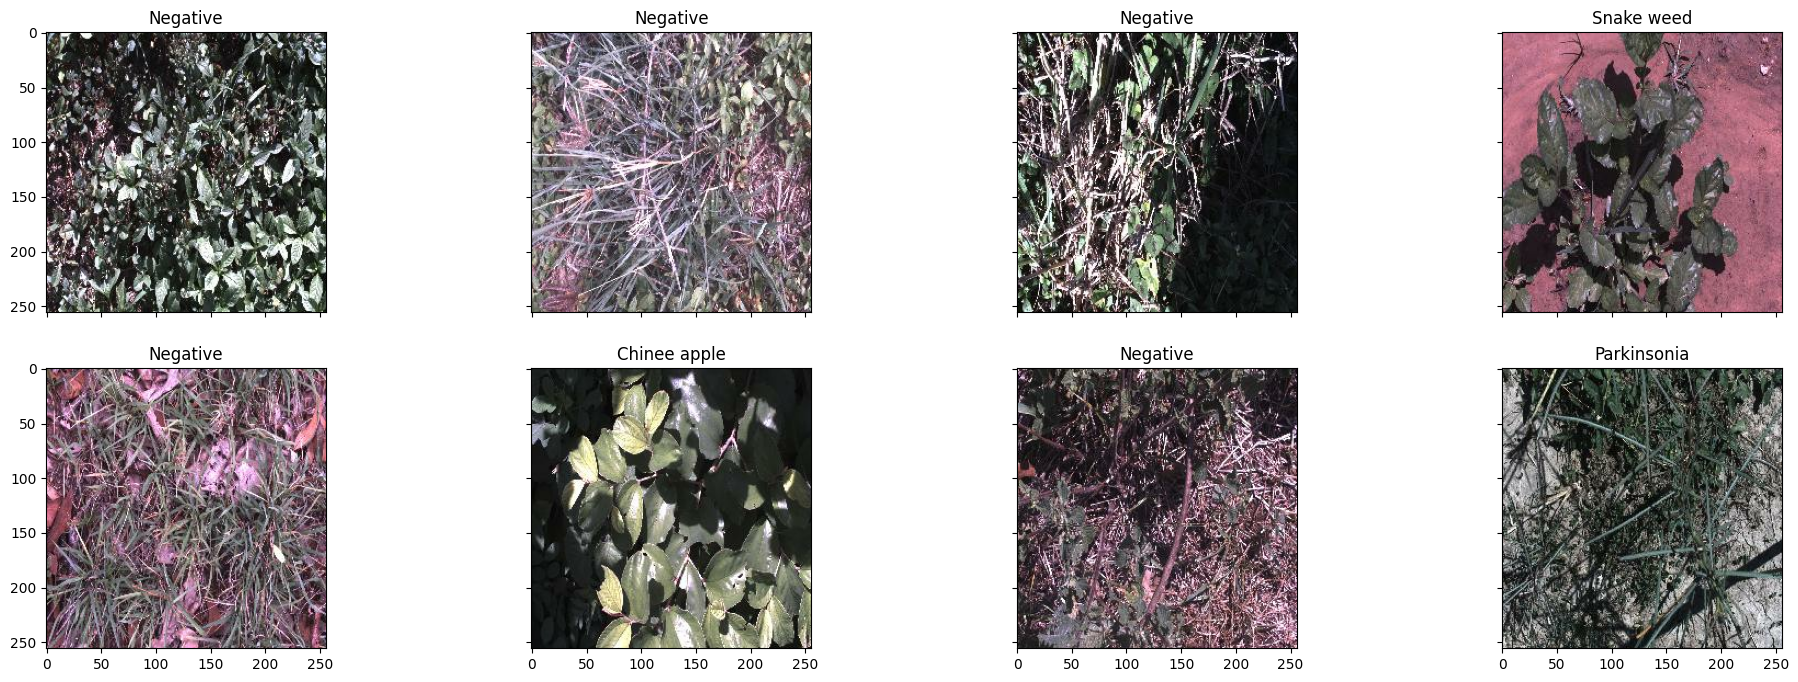

In [13]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

## Building InceptionV3 Model

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import efficientnet_v2

def buildModel(train=False):
    # Load the Inception model with weights pre-trained on ImageNet.
    base_model = efficientnet_v2.EfficientNetV2B2(weights='imagenet', include_top=False)
    base_model.trainable = train
    print("Base Model:", base_model.name)

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE)

    # Pre-process the input.
    x = layers.Resizing(224, 224)(inputs)
    x = layers.Rescaling(1./255)(inputs)
    #     x = tf.cast(x, tf.float32)
    #     print("Using Inception Preprocess_Input Layer")
    #     x = inception_v3.preprocess_input(x)
    
    ## DAta Augmentation
    x = layers.RandomBrightness(0.25, (0, 1),seed=seed)(x)
    x = layers.RandomContrast(0.1, seed=seed)(x)
    x = layers.GaussianDropout(0.05, seed=seed)(x)
    x = layers.RandomFlip(seed=seed)(x)
    x = layers.RandomRotation(0.5, seed=seed)(x)
    x = layers.RandomTranslation(0.2, 0.2, seed=seed)(x)
    x = layers.RandomZoom(0.2, 0.2, seed=seed)(x)

    # Pass the input through the pre-trained InceptionV3 model.
    x = base_model(x, training=train)    
    x = layers.Dropout(0.2)(x) 
    
    ## Add a global average pooling layer.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)

    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name="DeepWeeds-EfficientNetV2B2")
    return model

## Trial 1 - FineTuning

In [15]:
model = buildModel(train=True)
model.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base Model: efficientnetv2-b2


Model: "DeepWeeds-EfficientNetV2B2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 256, 256, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_dropout                │ (None, 256, 256, 3)    │             0 │
│ (GaussianDropout)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 256, 256, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 8, 8, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 1408)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        12,681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,782,055 (33.50 MB)

 Trainable params: 8,699,767 (33.19 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [16]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/100


2024-03-04 00:05:17.595632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/DeepWeeds-EfficientNetV2B2_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 ━━━━━━━━━━━━━━━━━━━━ 221s 317ms/step - accuracy: 0.5074 - loss: 1.3962 - val_accuracy: 0.4854 - val_loss: 1.5081
Epoch 2/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 303ms/step - accuracy: 0.7890 - loss: 0.6163 - val_accuracy: 0.5494 - val_loss: 1.3809
Epoch 3/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.8445 - loss: 0.4601 - val_accuracy: 0.5525 - val_loss: 1.7409
Epoch 4/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 148s 303ms/step - accuracy: 0.8696 - loss: 0.3776 - val_accuracy: 0.7850 - val_loss: 0.6447
Epoch 5/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 303ms/step - accuracy: 0.8975 - loss: 0.3116 - val_accuracy: 0.7413 - val_loss: 0.7335
Epoch 6/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 303ms/step - accuracy: 0.9066 - loss: 0.2715 - val_accuracy: 0.6825 - val_loss: 1.0392
Epoch 7/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9123 - loss: 0.2468 - val_accuracy: 0.6910 - val_loss: 1.1831
Epoch 8/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9280 - los

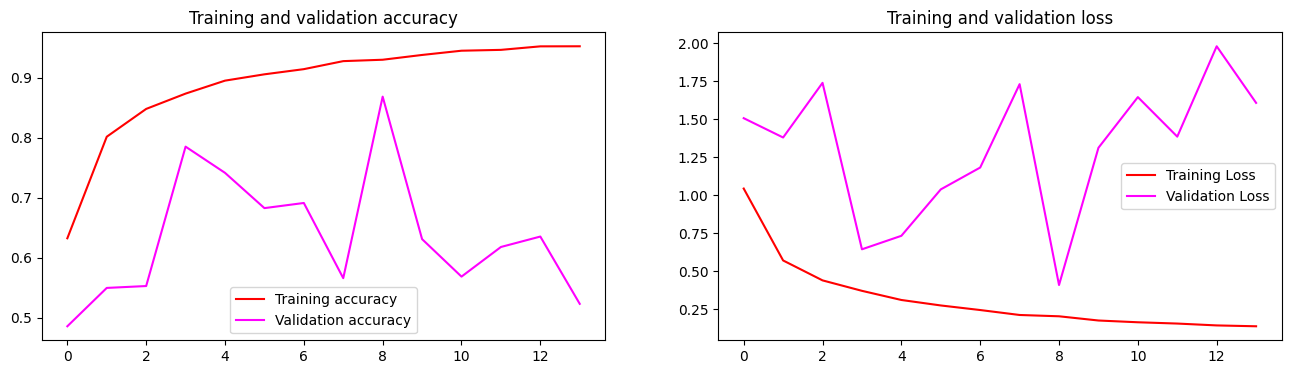

CPU times: user 36min 59s, sys: 6min 11s, total: 43min 11s
Wall time: 35min 34s


In [17]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=3e-2),
          metrics=['accuracy'])

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8702 - loss: 0.4158
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.92398   0.70222   0.79798       225
       Lantana    0.89888   0.75472   0.82051       212
   Parkinsonia    0.69310   0.97573   0.81048       206
    Parthenium    0.66436   0.93659   0.77733       205
Prickly acacia    0.80645   0.82160   0.81395       213
   Rubber vine    0.84956   0.95050   0.89720       202
     Siam weed    0.96216   0.82791   0.89000       215
    Snake weed    0.87978   0.79310   0.83420       203
      Negative    0.92116   0.89182   0.90625      1821

      accuracy                        0.86836      3502
     macro avg    0.84438   0.85046   0.83866      3502
  weighted avg    0.88055   0.86836   0.86961      3502


                False Positive Rate  Accuracy
Chinee apple               0.003967  0.702222
Lantana                    0.005471  0.754717
Parkinsonia                0.027002  0.975728
Parthenium                 0.029421  0.936585
Prickly acacia    

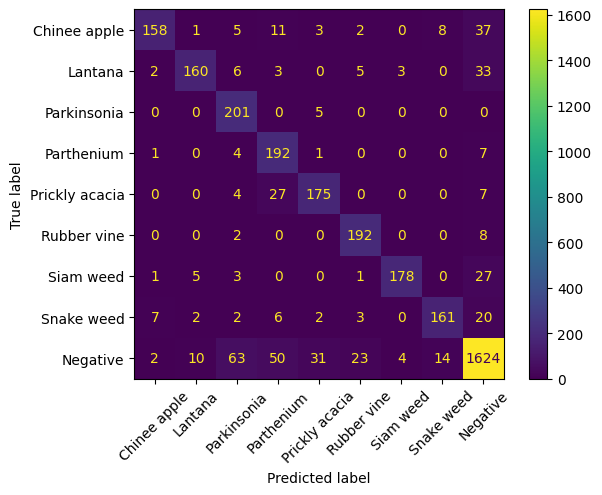

In [18]:
a, b = eval_model(model, validation_generator)

### Trial 2

Epoch 1/100


2024-03-04 00:41:22.344915: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/DeepWeeds-EfficientNetV2B2_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 ━━━━━━━━━━━━━━━━━━━━ 211s 309ms/step - accuracy: 0.9465 - loss: 0.1539 - val_accuracy: 0.9026 - val_loss: 0.3066
Epoch 2/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9550 - loss: 0.1369 - val_accuracy: 0.9112 - val_loss: 0.2790
Epoch 3/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 303ms/step - accuracy: 0.9560 - loss: 0.1240 - val_accuracy: 0.9058 - val_loss: 0.2882
Epoch 4/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9610 - loss: 0.1141 - val_accuracy: 0.9075 - val_loss: 0.2871
Epoch 5/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9622 - loss: 0.1105 - val_accuracy: 0.9206 - val_loss: 0.2568
Epoch 6/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9667 - loss: 0.1032 - val_accuracy: 0.9089 - val_loss: 0.2873
Epoch 7/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 149s 306ms/step - accuracy: 0.9666 - loss: 0.0978 - val_accuracy: 0.9118 - val_loss: 0.2763
Epoch 8/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9595 - los

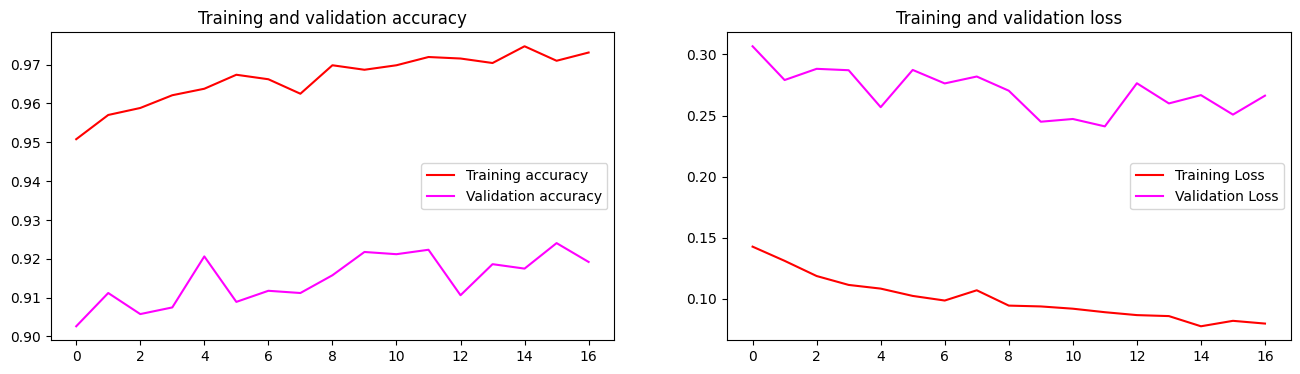

model.evaluate
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9184 - loss: 0.2373
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87500   0.84000   0.85714       225
       Lantana    0.92965   0.87264   0.90024       212
   Parkinsonia    0.90991   0.98058   0.94393       206
    Parthenium    0.76744   0.96585   0.85529       205
Prickly acacia    0.86900   0.93427   0.90045       213
   Rubber vine    0.90826   0.98020   0.94286       202
     Siam weed    0.94931   0.95814   0.95370       215
    Snake weed    0.83182   0.90148   0.86525       203
      Negative    0.96924   0.91708   0.94244      1821

      accuracy                        0.92233      3502
     macro avg    0.88996   0.92780   0.90681      3502
  weighted avg    0.92668   0.92233   0.92308      3502


                False Positive Rate  Accuracy
Chinee apple               0.008239  0.840000
Lantana                    0.004255  0.872642
Parkinsonia                0.006068  0.980583
Parthenium                 0.018198  0.965854
Prickly acacia    

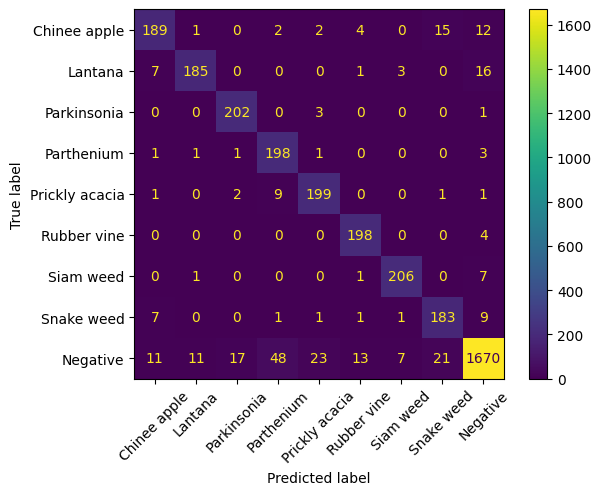

CPU times: user 45min 11s, sys: 7min 34s, total: 52min 45s
Wall time: 43min 10s


In [19]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-5,  weight_decay=3e-4),
          metrics=['accuracy'])

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)
a, b = eval_model(model, validation_generator)

## Trial 3

Epoch 1/100


2024-03-04 01:24:38.148064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/DeepWeeds-EfficientNetV2B2_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 ━━━━━━━━━━━━━━━━━━━━ 211s 309ms/step - accuracy: 0.9725 - loss: 0.0852 - val_accuracy: 0.9155 - val_loss: 0.2668
Epoch 2/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 303ms/step - accuracy: 0.9692 - loss: 0.0855 - val_accuracy: 0.9178 - val_loss: 0.2676
Epoch 3/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9723 - loss: 0.0820 - val_accuracy: 0.9172 - val_loss: 0.2648
Epoch 4/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 303ms/step - accuracy: 0.9708 - loss: 0.0851 - val_accuracy: 0.9226 - val_loss: 0.2563
Epoch 5/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 147s 302ms/step - accuracy: 0.9713 - loss: 0.0813 - val_accuracy: 0.9143 - val_loss: 0.2771
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Saving the Model


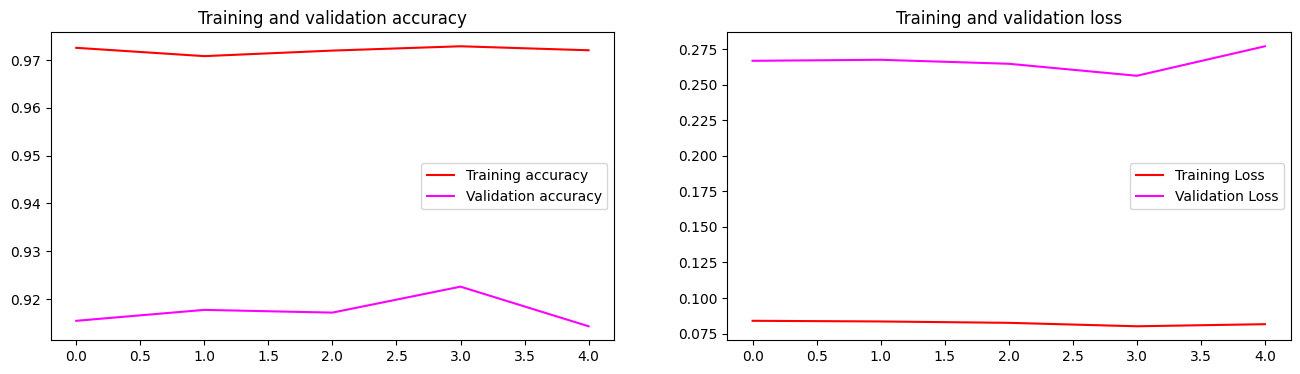

model.evaluate
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9152 - loss: 0.2541
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87736   0.82667   0.85126       225
       Lantana    0.91960   0.86321   0.89051       212
   Parkinsonia    0.90909   0.97087   0.93897       206
    Parthenium    0.71326   0.97073   0.82231       205
Prickly acacia    0.85714   0.92958   0.89189       213
   Rubber vine    0.94712   0.97525   0.96098       202
     Siam weed    0.95794   0.95349   0.95571       215
    Snake weed    0.80000   0.92611   0.85845       203
      Negative    0.96831   0.90610   0.93617      1821

      accuracy                        0.91548      3502
     macro avg    0.88331   0.92467   0.90069      3502
  weighted avg    0.92273   0.91548   0.91688      3502


                False Positive Rate  Accuracy
Chinee apple               0.007934  0.826667
Lantana                    0.004863  0.863208
Parkinsonia                0.006068  0.970874
Parthenium                 0.024264  0.970732
Prickly acacia    

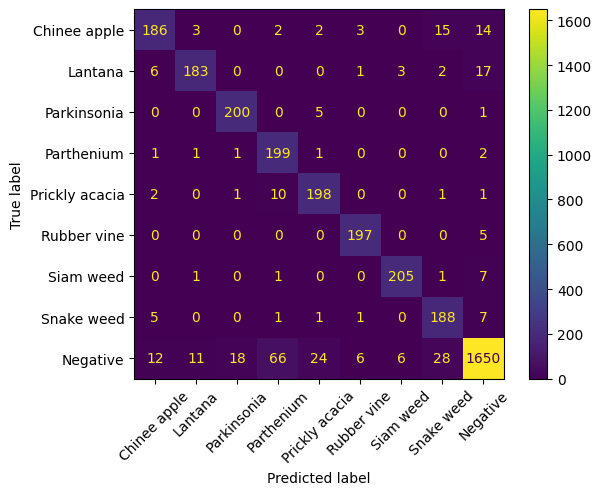

CPU times: user 14min 23s, sys: 2min 12s, total: 16min 35s
Wall time: 13min 47s


In [20]:
%%time
model.compile(loss='categorical_crossentropy',
              optimizer=AdamW(learning_rate=5e-6,  weight_decay=3e-5),
              metrics=['accuracy'])

# Train the model
history3 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history3.history)
a, b = eval_model(model, validation_generator)

### Trial 4 - Freezing Base Model

Freezing Layer efficientnetv2-b2
Epoch 1/100


2024-03-04 01:37:55.479058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/DeepWeeds-EfficientNetV2B2_1/efficientnetv2-b2_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 ━━━━━━━━━━━━━━━━━━━━ 65s 98ms/step - accuracy: 0.9825 - loss: 0.0527 - val_accuracy: 0.9158 - val_loss: 0.2662
Epoch 2/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.9822 - loss: 0.0537 - val_accuracy: 0.9158 - val_loss: 0.2660
Epoch 3/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.9825 - loss: 0.0532 - val_accuracy: 0.9158 - val_loss: 0.2658
Epoch 4/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.9819 - loss: 0.0565 - val_accuracy: 0.9158 - val_loss: 0.2654
Epoch 5/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 44s 91ms/step - accuracy: 0.9808 - loss: 0.0589 - val_accuracy: 0.9163 - val_loss: 0.2649
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Saving the Model


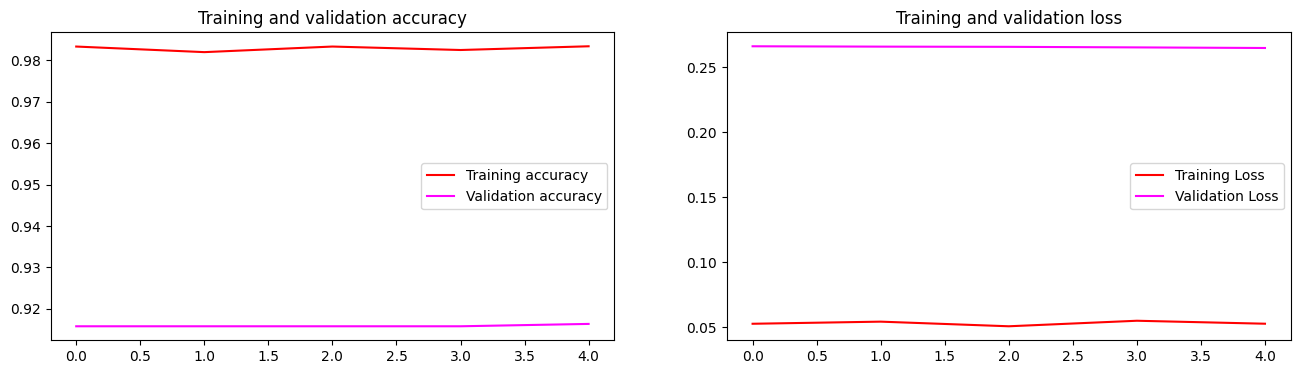

In [21]:
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)

for layer in model.layers:
    if('efficient' in layer.name):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break
        
model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=1e-5),
  metrics=['accuracy'])

# Train the model
history4 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history4.history)

## Evaluations

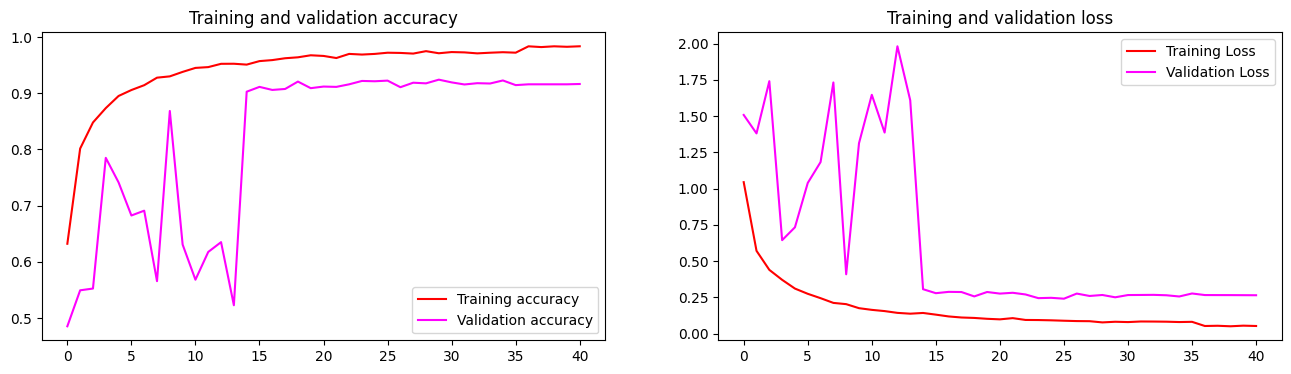

In [22]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])
    history[key].extend(history3.history[key])
    history[key].extend(history4.history[key])
    

plot_loss_acc(history)

model.evaluate
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9146 - loss: 0.2637
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.87736   0.82667   0.85126       225
       Lantana    0.91960   0.86321   0.89051       212
   Parkinsonia    0.90909   0.97087   0.93897       206
    Parthenium    0.71583   0.97073   0.82402       205
Prickly acacia    0.85714   0.92958   0.89189       213
   Rubber vine    0.94712   0.97525   0.96098       202
     Siam weed    0.95794   0.95349   0.95571       215
    Snake weed    0.80000   0.92611   0.85845       203
      Negative    0.96833   0.90664   0.93647      1821

      accuracy                        0.91576      3502
     macro avg    0.88360   0.92473   0.90092      3502
  weighted avg    0.92289   0.91576   0.91714      3502


                False Positive Rate  Accuracy
Chinee apple               0.007934  0.826667
Lantana                    0.004863  0.863208
Parkinsonia                0.006068  0.970874
Parthenium                 0.023961  0.970732
Prickly acacia    

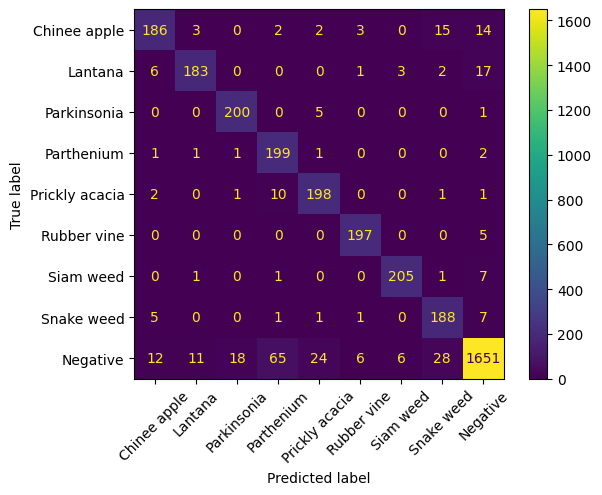

'Threshold = 0.1111111119389534'

In [23]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

thresholds = []
for i in range(len(a)):
    n_label = prediction_argmax(b[i])
    ap_label = np.argmax(b[i])
    a_label = a[i]

    if(n_label == a_label):
        thresholds.append(b[n_label])


rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

### Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9126 - loss: 0.2833
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.86784   0.87556   0.87168       225
       Lantana    0.90865   0.88732   0.89786       213
   Parkinsonia    0.91781   0.97573   0.94588       206
    Parthenium    0.71014   0.96078   0.81667       204
Prickly acacia    0.85590   0.92453   0.88889       212
   Rubber vine    0.95122   0.96535   0.95823       202
     Siam weed    0.96714   0.95814   0.96262       215
    Snake weed    0.85714   0.88670   0.87167       203
      Negative    0.96091   0.90445   0.93182      1821

      accuracy                        0.91602      3501
     macro avg    0.88853   0.92651   0.90504      3501
  weighted avg    0.92205   0.91602   0.91734      3501


                False Positive Rate  Accuracy
Chinee apple               0.009158  0.875556
Lantana                    0.005779  0.887324
Parkinsonia                0.005463  0.975728
Parthenium                 0.024264  0.960784
Prickly acacia    

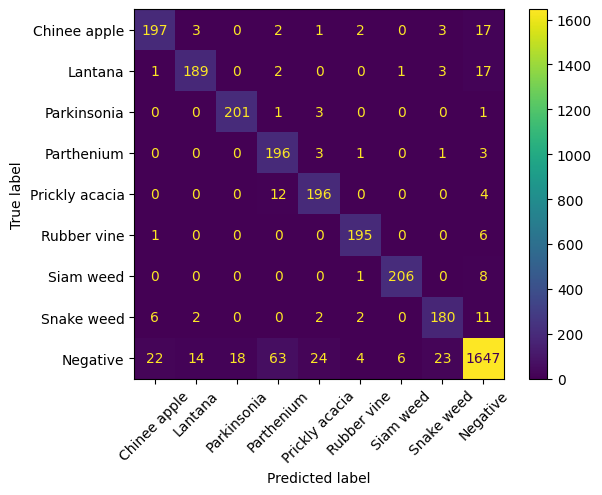

In [24]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

### Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.80709   0.91111   0.85595       225
       Lantana    0.83544   0.92958   0.88000       213
   Parkinsonia    0.91364   0.97573   0.94366       206
    Parthenium    0.70652   0.95588   0.81250       204
Prickly acacia    0.80242   0.93868   0.86522       212
   Rubber vine    0.94660   0.96535   0.95588       202
     Siam weed    0.96729   0.96279   0.96503       215
    Snake weed    0.85646   0.88177   0.86893       203
      Negative    0.97495   0.87644   0.92308      1821

      accuracy                        0.90688      3501
     macro avg    0.86782   0.93304   0.89670      3501
  weighted avg    0.91700   0.90688   0.90874      3501


                False Positive Rate  Accuracy
Chinee apple               0.014957  0.911111
Lantana            

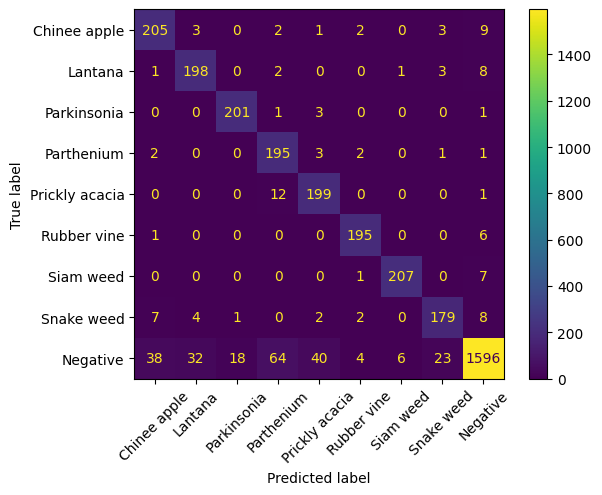

In [25]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b,rand_guess)

In [26]:
shutil.rmtree(base_dir)